In [ ]:
import torch
from torch.utils.data import DataLoader ,Dataset
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import ImageOps

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"the device is : {device}")

the device is : cuda


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((56,56)),
    transforms.Lambda(lambda img: ImageOps.invert(img)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root='/kaggle/input/handwritten-math-symbols/dataset', transform=transform)

In [ ]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
print(idx_to_class)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'add', 11: 'dec', 12: 'div', 13: 'eq', 14: 'mul', 15: 'sub', 16: 'x', 17: 'y', 18: 'z'}


In [ ]:
from torch.utils.data import random_split

# Define split lengths
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
img,label=train_dataset[0]
print(f"the max pixel is :{img.max().item()} the min is :{img.min().item()}")

the max pixel is :1.0 the min is :-1.0


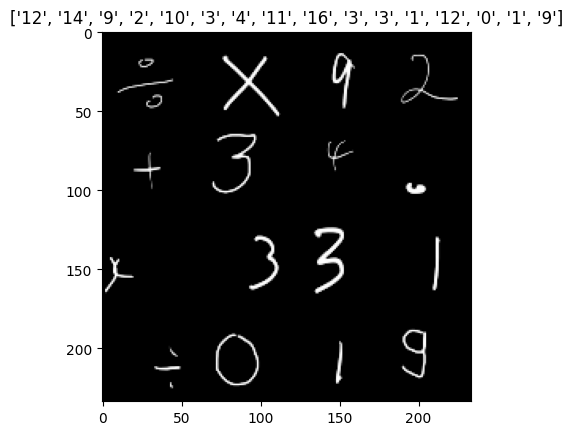

In [ ]:
import matplotlib.pyplot as plt
import torchvision

# show one batch
images, labels = next(iter(train_loader))

# plot few images
grid = torchvision.utils.make_grid(images[:16], nrow=4)
plt.imshow(grid.permute(1, 2, 0))
plt.title([str(l.item()) for l in labels[:16]])
plt.show()

In [ ]:
print(len(test_loader))

32


In [ ]:
import torch.nn.init as init

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)

    elif isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)

    elif isinstance(m, nn.BatchNorm2d):
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

In [ ]:
class cnn(nn.Module):
    def __init__(self,n_channel):
        super().__init__()
        self.features=nn.Sequential(
            nn.Conv2d(n_channel,16,kernel_size=3,padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(16,32,kernel_size=3,padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(32,64,kernel_size=3,padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),


        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7,256),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(64,19)
        )


    def forward(self,x):
        x= self.features(x)
        x=self.classifier(x)

        return x


In [ ]:
alpha=0.001
epochs=100

model = cnn(1)
model.apply(init_weights)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=alpha)
model.to(device)

cnn(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inpla

In [ ]:
for epoch in range (epochs):
    total_loss=0
    for batch_features ,batch_label in train_loader :
        batch_features,batch_label=batch_features.to(device),batch_label.to(device)
        y_hat=model(batch_features)

        loss=criterion(y_hat,batch_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss=total_loss+loss.item()
    avg_loss=total_loss/(len(train_loader))
    print(f" epoch : {epoch+1}  loss={avg_loss:.4f}")


 epoch : 1  loss=2.8902
 epoch : 2  loss=2.3618
 epoch : 3  loss=2.1182
 epoch : 4  loss=1.9809
 epoch : 5  loss=1.8675
 epoch : 6  loss=1.7829
 epoch : 7  loss=1.6865
 epoch : 8  loss=1.6016
 epoch : 9  loss=1.5191
 epoch : 10  loss=1.4584
 epoch : 11  loss=1.3929
 epoch : 12  loss=1.3857
 epoch : 13  loss=1.3279
 epoch : 14  loss=1.2888
 epoch : 15  loss=1.2410
 epoch : 16  loss=1.2448
 epoch : 17  loss=1.2142
 epoch : 18  loss=1.1689
 epoch : 19  loss=1.1658
 epoch : 20  loss=1.1226
 epoch : 21  loss=1.1102
 epoch : 22  loss=1.0466
 epoch : 23  loss=1.0381
 epoch : 24  loss=1.0106
 epoch : 25  loss=1.0038
 epoch : 26  loss=0.9855
 epoch : 27  loss=0.9738
 epoch : 28  loss=0.9434
 epoch : 29  loss=0.9170
 epoch : 30  loss=0.8951
 epoch : 31  loss=0.8890
 epoch : 32  loss=0.8497
 epoch : 33  loss=0.8400
 epoch : 34  loss=0.8157
 epoch : 35  loss=0.7908
 epoch : 36  loss=0.7874
 epoch : 37  loss=0.7799
 epoch : 38  loss=0.7627
 epoch : 39  loss=0.7494
 epoch : 40  loss=0.7090
 epoch : 

In [ ]:
model.eval()
total=0
correct=0

all_preds = []
all_labels = []
with torch.no_grad():
    for X,y in test_loader:
        label=y
        X,y =X.to(device),y.to(device)
        yhat=model(X)
        _,predicted=torch.max(yhat,1)
        total=total+X.shape[0]
        correct=correct+(predicted==y).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
    print(correct/total)

0.9439205955334987


In [ ]:
model.eval()
total=0
correct=0
with torch.no_grad():
    for X,y in train_loader:
        X,y =X.to(device),y.to(device)
        yhat=model(X)
        _,predicted=torch.max(yhat,1)
        total=total+X.shape[0]
        correct=correct+(predicted==y).sum().item()
    print(correct/total)

0.987462760675273


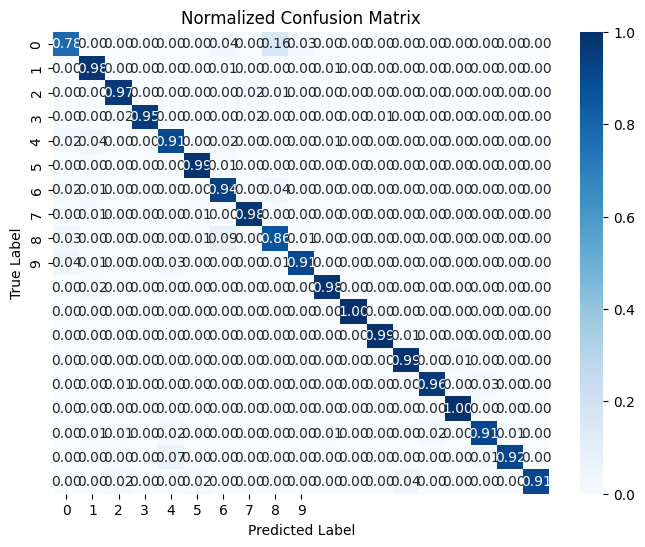

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels,all_preds)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'digit_model.pth')
